In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from flaml import AutoML
from flaml.default import LGBMRegressor
from flaml.automl.data import load_openml_dataset
import sklearn

## Upload data frame (train)

In [2]:
df = pd.read_csv("train.csv")

## Visualize data frame (train)

In [3]:
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1


In [4]:
df.shape

(159256, 24)

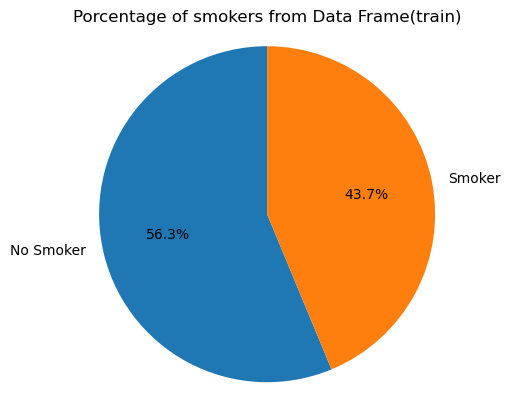

In [5]:
import matplotlib.pyplot as plt

# Calculate percentage smokers vs no smokers
percentage_smoking = df["smoking"].value_counts(normalize=True) * 100

# Create Pie Chart
labels = ["No Smoker", "Smoker"]
plt.pie(percentage_smoking, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Porcentage of smokers from Data Frame(train)")
plt.axis("equal")  

plt.show()

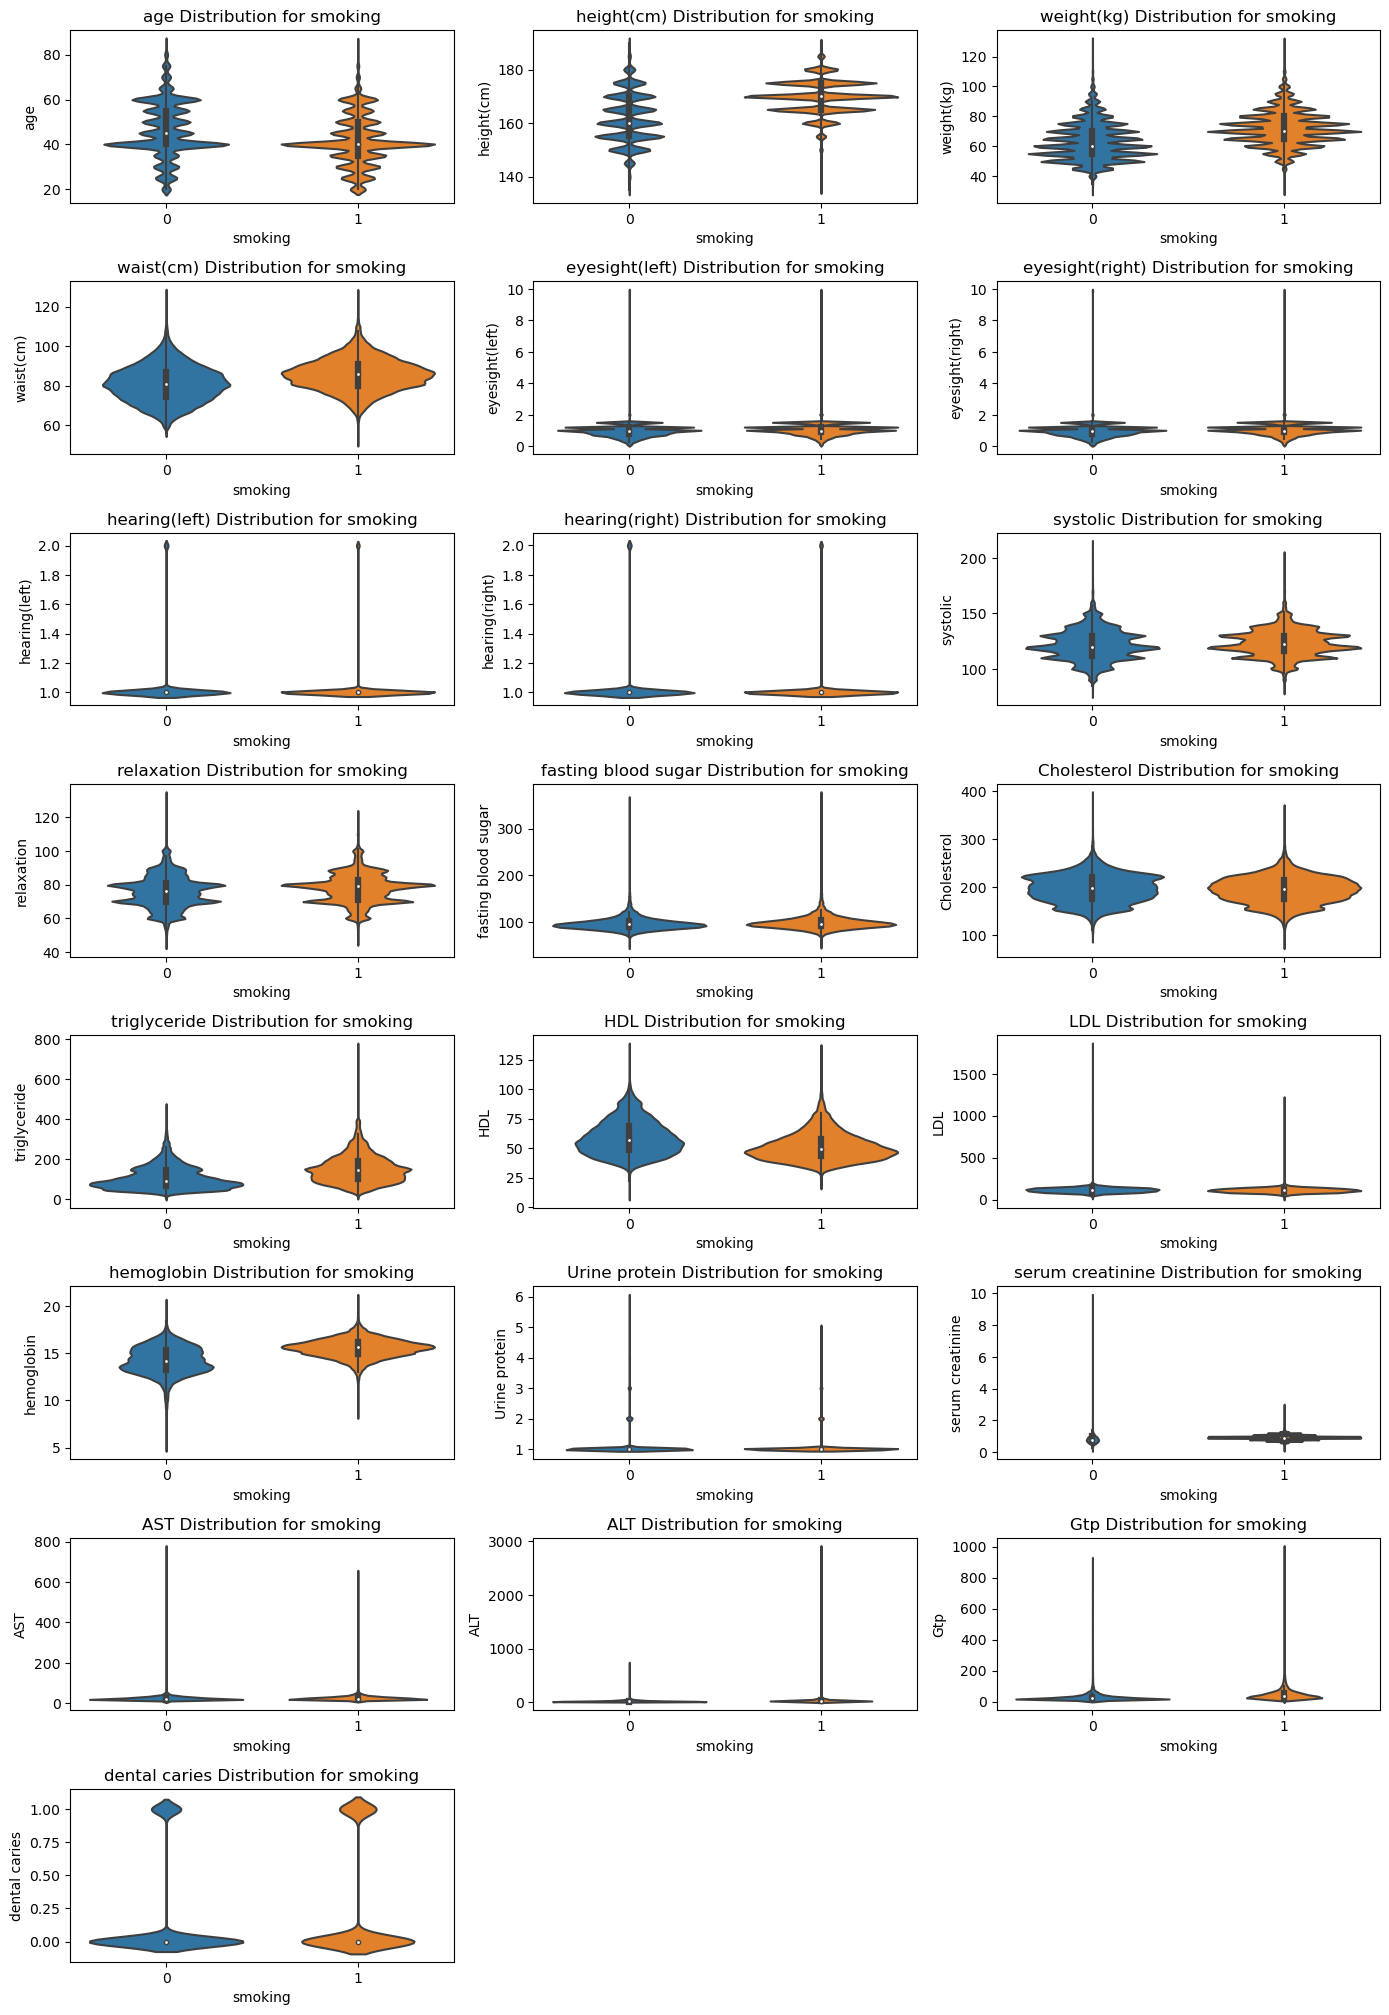

In [6]:
num_var = df.columns[1:-1] 
target = "smoking"  

num_rows = len(num_var)
num_cols = 3

total_plots = num_rows * num_cols
plt.figure(figsize=(14, num_rows * 2.5))

for idx, col in enumerate(num_var):
    plt.subplot(num_rows, num_cols, idx % total_plots + 1)
    sns.violinplot(x=target, y=col, data=df)
    plt.title(f"{col} Distribution for {target}")

plt.tight_layout()
plt.show()

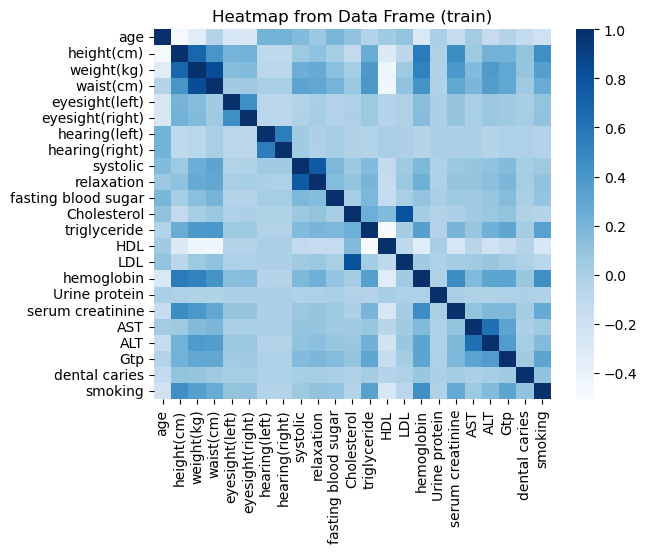

In [7]:
sns.heatmap(df.iloc[:,1:].corr(),cmap="Blues")
plt.title("Heatmap from Data Frame (train)")
plt.show()

Text(0.5, 1.0, 'Dental Caries Vs Smoking Habits')

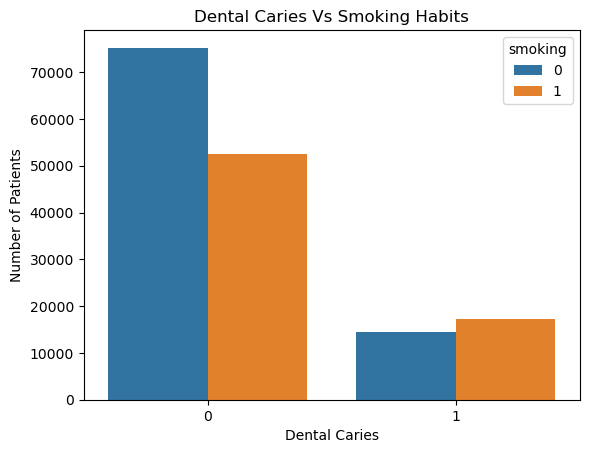

In [8]:
sns.countplot(data=df, x='dental caries', hue='smoking')
plt.xlabel('Dental Caries')
plt.ylabel('Number of Patients')
plt.title('Dental Caries Vs Smoking Habits')

## Edit data frame (train)

In [9]:
def transforma(df):
    
    # Create columns:
    
    # Age intervals
    age_bins = [15, 25, 35, 45, 55, 65, 75, 85, float("inf")]
    age_labels = ["15–24", "25–34", "35–44", "45–54", "55–64", "65–74", "75–84", "85 o más"]

    df["age_interval"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, include_lowest=True, right=False)

    age_dummies = pd.get_dummies(df["age_interval"], prefix="age")
    df = pd.concat([df, age_dummies], axis=1)

    # IMC
    df["IMC"] = round(df["weight(kg)"] / ((df["height(cm)"] / 100) ** 2),1)

    # IMC classification
    conditions = [
        (df["IMC"] < 18.5),
        (df["IMC"] >= 18.5) & (df["IMC"] < 25),
        (df["IMC"] >= 25) & (df["IMC"] < 30),
        (df["IMC"] >= 30)
    ]
    choices = ["Insuficiencia", "Normal", "Sobrepeso", "Obesidad"]
    df["Clasificacion_IMC"] = np.select(conditions, choices, default='Valor no clasificado')

    # IMC classification (dummies)
    dummies_IMC = pd.get_dummies(df["Clasificacion_IMC"], prefix="IMC_Clasificacion")
    df = pd.concat([df, dummies_IMC], axis=1)
    
    # waist/height
    df["waist(cm)/height(cm)"] = round(df["waist(cm)"] / df["height(cm)"],1)

    # height/age
    df["height(cm)/age"] = df["height(cm)"] / df["age"]
    
    # PAM 
    df["PAM"] = round((df["systolic"] + (df["relaxation"]*2))/3,1)

    # Pulse
    df["Pulse"] = df["systolic"] - df["relaxation"]

    # Cholesterol/HDL
    df["Cholesterol/HDL"] = round(df["Cholesterol"] / df["HDL"],1)

    # Cholesterol/LDL 
    df["Cholesterol/LDL"] = round(df["Cholesterol"] / df["LDL"],1)

    # HDL/LDL 
    df["HDL/LDL"] = round(df["HDL"] / df["LDL"],1)

    # AST/ALT 
    df["AST/ALT"] = round(df["AST"]/df["ALT"],1)
    
    # Delete columns
    columns_to_drop = ["hearing(left)","hearing(right)", "age_interval", "Clasificacion_IMC"]  
    df = df.drop(columns=columns_to_drop, axis=1)
    
    
    return df

In [10]:
df = transforma(df)

## X and target (train)

In [11]:
X = df.drop(["id","smoking"], axis=1)
y = df["smoking"]

## Split data frame (train) in train and test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

## AutoML finds the best parameters for XGBOOST model (train)

In [13]:
model = AutoML()
model_settings = {
    "task": "classification",
    "starting_points": "data",
    "estimator_list": ["xgboost"],
    "time_budget": 1000,
    "max_iter": 50
}
model.fit(X_train, y_train, **model_settings)

# Train
y_predict=model.predict(X_train)
probs=model.predict_proba(X_train)
print("Train AUC:", sklearn.metrics.roc_auc_score(y_train,probs[:,1]))

# Test
y_predict=model.predict(X_test)
probs=model.predict_proba(X_test)
print("Test AUC:", sklearn.metrics.roc_auc_score(y_test,probs[:,1]))

[flaml.automl.logger: 11-20 11:22:09] {1679} INFO - task = classification
[flaml.automl.logger: 11-20 11:22:09] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 11-20 11:22:09] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 11-20 11:22:09] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 11-20 11:22:09] {2218} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 11-20 11:22:54] {2344} INFO - Estimated sufficient time budget=5153452s. Estimated necessary time budget=5153s.
[flaml.automl.logger: 11-20 11:22:54] {2391} INFO -  at 46.4s,	estimator xgboost's best error=0.1500,	best estimator xgboost's best error=0.1500
[flaml.automl.logger: 11-20 11:22:54] {2218} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 11-20 11:23:37] {2391} INFO -  at 89.4s,	estimator xgboost's best error=0.1435,	best estimator xgboost's best error=0.1435
[flaml.automl.logger: 11-20 11:23:37] {2218} INFO - iterati

## Upload data frame (test)


In [14]:
df_test = pd.read_csv("test.csv")

## Edit data frame (test)

In [15]:
df_test = transforma(df_test)

## X (test)

In [16]:
X_test = df_test.drop(["id"],axis=1)

## Smoking predictions for data frame (test)

In [17]:
predict = model.predict_proba(X_test)

In [18]:
predict

array([[0.38369155, 0.61630845],
       [0.7408161 , 0.2591839 ],
       [0.6228049 , 0.37719512],
       ...,
       [0.55244225, 0.44755775],
       [0.9318731 , 0.0681269 ],
       [0.966791  , 0.03320904]], dtype=float32)

In [19]:
predict[:,1]

array([0.61630845, 0.2591839 , 0.37719512, ..., 0.44755775, 0.0681269 ,
       0.03320904], dtype=float32)

## Create data frame for submission

In [20]:
df = pd.DataFrame({"id": df_test["id"], "smoking": predict[:,1]})
df.head()

,id,smoking
0,159256,0.616308
1,159257,0.259184
2,159258,0.377195
3,159259,0.021255
4,159260,0.592336


## Create CSV 

In [21]:
df.to_csv("SmokerPrediction.csv", index=False)